q: Input

x: neuron value / output

w: weight

b: bias

z: neuron-internal value fed into the activation function

In [1]:
import numpy as np

# random input
q1 = np.random.uniform(-1, 1, 1_000)
q2 = np.random.uniform(-1, 1, 1_000)

def f(q1, q2):

    # linear
    X1 = q1 + q2 - 1
    X2 = q1 - q2 + 1

    # Nonlinear
    #X1 = q1 + (q2 ** 2) - 1
    #X2 = q1 - q2 + 1

    return X1, X2

X1, X2 = f(q1, q2)


## Define the Neuron

## Network Structure Diagram

Below is a diagram showing the structure of the neural network used in this notebook. The network consists of 4 layers (including input and output), each with 2 neurons, and all connections are fully connected between adjacent layers.

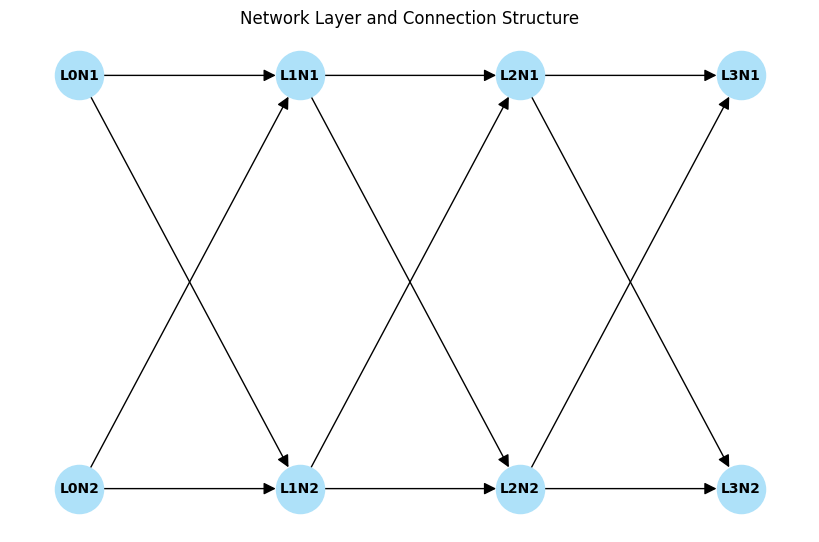

In [2]:
import matplotlib.pyplot as plt
import networkx as nx

# Define the network structure
layers = [2, 2, 2, 2]  # 4 layers, 2 neurons each
G = nx.DiGraph()

# Add nodes for each neuron in each layer
positions = {}
labels = {}
layer_gap = 2
neuron_gap = 1.2
for l, n_count in enumerate(layers):
    for n in range(n_count):
        node = f"L{l}N{n+1}"
        G.add_node(node)
        # Position: (layer, neuron)
        positions[node] = (l * layer_gap, -n * neuron_gap + (n_count-1)*neuron_gap/2)
        labels[node] = f"{node}"

# Add edges (fully connected between adjacent layers)
for l in range(len(layers)-1):
    for n1 in range(layers[l]):
        for n2 in range(layers[l+1]):
            G.add_edge(f"L{l}N{n1+1}", f"L{l+1}N{n2+1}")

plt.figure(figsize=(8, 5))
nx.draw(G, pos=positions, with_labels=True, labels=labels, node_size=1200, node_color="#aee1f9", font_size=10, arrowsize=18, font_weight='bold')
plt.title("Network Layer and Connection Structure")
plt.axis('off')
plt.show()

In [3]:

def sigmoid(z):
    return 1/(1 + np.exp(-z))

def activation_func(z, i_layer):

    if i_layer != 0 and i_layer != 2:
       return z

    #return sigmoid(z)
    #return np.tanh(z)
    return z
    # if z < 0:
    #     return z * 0.1
    # return z

def neuron(u, w, b, i_layer):
    # u is a vector, w is a vector of same length, compute dot product
    z = np.dot(u, w) + b
    x = activation_func(z, i_layer)
    return x

# q: input vector
# w: weights matrix 3-dimensional (layer, neuron, weight)
# b: bias matrix 2-dimensional (layer, neuron)
def forward(q, w, b):
    u = np.array(q)
    for layer in range(len(w)):
        u_next = []
        for neuron_idx in range(len(w[layer])):
            w_n = w[layer][neuron_idx]
            b_n = b[layer][neuron_idx]
            x = neuron(u, w_n, b_n, layer)
            u_next.append(x)
        u = np.array(u_next)
    return u

    
def loss_func(x_ist, x_soll):
    return np.sum((np.array(x_ist) - np.array(x_soll))**2)

In [4]:
import copy

def train(start_w, start_b, u_set, x_m_set, learning_rate, epochs):
    w = copy.deepcopy(start_w)
    b = copy.deepcopy(start_b)
    loss_history = []
    
    for _epoch in range(epochs):


        w_for_epoch = copy.deepcopy(w)
        b_for_epoch = copy.deepcopy(b)

        loss_for_epoch = 0


        # for each epoch, train on all inputs
        for i in range(len(u_set)):
            u = u_set[i]
            x_m = x_m_set[i]

            # forward prop
            x = forward(u, w, b)
            loss = loss_func(x, x_m)

            loss_for_epoch += loss

            epsilon = 1e-6

            # iterate over layers
            for i_1 in range(len(w)):
                # neurons
                for i_2 in range(len(w[i_1])):
                    # connections
                    for i_3 in range(len(w[i_1][i_2])):
                        # wiggle w a little bit
                        w_perturbed = copy.deepcopy(w)
                        w_perturbed[i_1][i_2][i_3] += epsilon
                        x_perturbed = forward(u, w_perturbed, b)
                        loss_perturbed_pos = loss_func(x_perturbed, x_m)

                        w_perturbed = copy.deepcopy(w)
                        w_perturbed[i_1][i_2][i_3] -= epsilon
                        x_perturbed = forward(u, w_perturbed, b)
                        loss_perturbed_neg = loss_func(x_perturbed, x_m)

                        grad_w = (loss_perturbed_pos - loss_perturbed_neg) / (2 * epsilon)
                        w_for_epoch[i_1][i_2][i_3] -= learning_rate * grad_w
                    
                    

                    # wiggle b
                    b_perturbed = copy.deepcopy(b)
                    b_perturbed[i_1][i_2] += epsilon
                    x_perturbed = forward(u, w, b_perturbed)
                    loss_perturbed_pos = loss_func(x_perturbed, x_m)

                    b_perturbed = copy.deepcopy(b)
                    b_perturbed[i_1][i_2] -= epsilon
                    x_perturbed = forward(u, w, b_perturbed)
                    loss_perturbed_neg = loss_func(x_perturbed, x_m)

                    grad_b = (loss_perturbed_pos - loss_perturbed_neg) / (2 * epsilon)
                    b_for_epoch[i_1][i_2] -= learning_rate * grad_b
                    
        # after training on all inputs, update w and b
        w = w_for_epoch
        b = b_for_epoch

        loss_history.append(loss_for_epoch)
    
    return w, b, loss_history

# Training

In [5]:

start_w = [
    #np.random.uniform(-1, 1, (2, 2)),  # input layer: 2 neurons, 2 inputs each
    np.random.uniform(-1, 1, (2, 2)),  # hidden layer: 2 neurons, 2 inputs each
    np.random.uniform(-1, 1, (2, 2)),  # hidden layer: 2 neurons, 2 inputs each
    np.random.uniform(-1, 1, (2, 2))   # output layer: 2 neurons, 2 inputs each
    
    # np.zeros((2, 2)),
    # np.zeros((2, 2)),
    # np.zeros((2, 2)),
    # np.zeros((2, 2))
]

# Bias hardcoded to 0
start_b = [
    #np.zeros(2),  # input layer biases
    np.zeros(2),  # hidden layer biases
    np.zeros(2),  # hidden layer biases
    np.zeros(2)   # output layer biases
]

# input
q = [[q1[i], q2[i]] for i in range(len(q1))]

# output:
x_m = [[X1[i], X2[i]] for i in range(len(q1))]

w, b, loss_history = train(start_w, start_b, q, x_m, learning_rate=0.0001, epochs=90)

print(f"Trained weight: {w}")
print(f"Trained bias: {b}")
print(f"Final loss: {loss_history[-1]:.4f}")

Trained weight: [array([[-0.75225686,  1.01375703],
       [-1.08096929, -0.48629463]]), array([[-1.12099691,  0.84723316],
       [ 0.75190319,  0.69136674]]), array([[-0.84256561, -0.71507111],
       [ 0.42972609, -0.78537858]])]
Trained bias: [array([-0.19851205,  0.07431331]), array([0.23303685, 0.1325893 ]), array([-0.53828866,  0.80443131])]
Final loss: 0.0000


In [6]:
import matplotlib.pyplot as plt

def show_loss(loss_history):

    plt.figure(figsize=(10, 6))
    plt.plot(loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Time During Training')
    plt.grid(True, alpha=0.3)
    plt.yscale('log')  # Log scale helps visualize the convergence better
    plt.show()

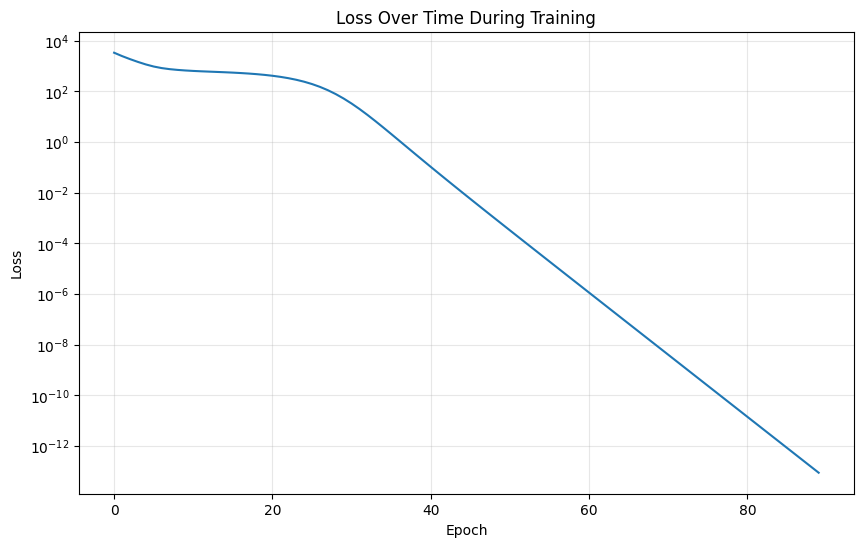

In [7]:
show_loss(loss_history)

# Error over Input Parameter Space

In [8]:
import plotly.graph_objects as go

# Create a grid over the input space
grid_size = 100
q1_range = np.linspace(-1, 1, grid_size)
q2_range = np.linspace(-1, 1, grid_size)
Q1_grid, Q2_grid = np.meshgrid(q1_range, q2_range)

# Calculate error at each point
error_grid = np.zeros_like(Q1_grid)

for i in range(grid_size):
    for j in range(grid_size):
        test_q1, test_q2 = Q1_grid[i, j], Q2_grid[i, j]
        test_input = [test_q1, test_q2]
        
        # Get network output
        output = forward(test_input, w, b)
        
        # Calculate expected values (linear case)
        expected_X1, expected_X2 = f(test_q1, test_q2)
        
        # Calculate total error (sum of squared errors)
        error = (output[0] - expected_X1)**2 + (output[1] - expected_X2)**2
        error_grid[i, j] = error

# Create interactive 3D plot with Plotly
fig = go.Figure(data=[go.Surface(
    x=Q1_grid,
    y=Q2_grid,
    z=error_grid,
    colorscale='Viridis',
    colorbar=dict(title='Error')
)])

fig.update_layout(
    title='Network Error Over Input Parameter Space',
    scene=dict(
        xaxis_title='X1 (q1)',
        yaxis_title='X2 (q2)',
        zaxis_title='δ (Error)',
        #zaxis_type='log'
    ),
    width=800,
    height=700
)

fig.show()

print(f"Max error: {np.max(error_grid):.6f}")
print(f"Min error: {np.min(error_grid):.6f}")
print(f"Mean error: {np.mean(error_grid):.6f}")

Max error: 0.000000
Min error: 0.000000
Mean error: 0.000000


# Execution

In [9]:

test_q1, test_q2 = 0.5, 0.3
test_input = [test_q1, test_q2]
output = forward(test_input, w, b)

# Expected values based on the training targets
expected_X1, expected_X2 = f(test_q1, test_q2)

print(f"Input: q1={test_q1}, q2={test_q2}")
print(f"Network output: X1={output[0]:.4f}, X2={output[1]:.4f}")
print(f"Expected:       X1={expected_X1:.4f}, X2={expected_X2:.4f}")

Input: q1=0.5, q2=0.3
Network output: X1=-0.2000, X2=1.2000
Expected:       X1=-0.2000, X2=1.2000
